In [70]:
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pyrsig
import pyproj
import pycno
import pandas as pd
from matplotlib.colors import TwoSlopeNorm

In [71]:
start_date = '2023-06-04'
end_date = '2023-06-05'

In [72]:
droot = '/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/run/final_scale_factors/'
# droot = '/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/run/scale_factors/'

In [73]:
dates = pd.date_range(start_date, end_date, freq='1D').strftime('%Y%m%d')
startf = dates[0]
endf = dates[-1]

In [74]:
run_name = 'SCALE8_FINAL'
# run_name = 'SCALE10T'

In [75]:
dfs = []
for d in dates:
    file = f'{droot}/{run_name}/DAILY_SCALE_{d}.nc'
    # print(file)
    f = xr.open_dataset(file)
    dfs.append(f)   
df = xr.concat(dfs, dim='TSTEP')

In [76]:
scf_avg = df['SCALE'].isel(LAY=0).mean(dim='TSTEP') * 1000
beta = df['BETA'].isel(LAY=0).mean(dim='TSTEP')

In [77]:
print(f'min: {scf_avg.quantile(0).values}')
print(f'mean: {scf_avg.mean().values}')
print(f'max: {scf_avg.quantile(1).values}')

min: 0.5
mean: 0.997230589389801
max: 2.0


In [78]:
print(f"IQR: {scf_avg.quantile(0.25).values} , {scf_avg.quantile(0.5).values}, {scf_avg.quantile(0.75).values}")
print(f"10th/90th pct: {scf_avg.quantile(0.10).values}, {scf_avg.quantile(0.90).values}")

IQR: 1.0 , 1.0, 1.0
10th/90th pct: 0.9797146916389465, 1.0067777037620544


In [79]:
bad_days = []
for d in dates:
    file = f'{droot}/{run_name}/DAILY_SCALE_{d}.nc'
    ds = xr.open_dataset(file)
    scf = ds['SCALE'].isel(LAY=0) * 1000
    if np.all(np.isclose(scf, 1)):
        bad_days.append(d)
    ds.close()
    # Yes, this function correctly finds days where all scale factors are 1 (within floating point tolerance).
    # Flag days where 90% or more of SCALE values are close to 1
    frac_ones = np.isclose(scf, 1).sum() / scf.size
    if frac_ones >= 0.9:
        bad_days.append(d)
if bad_days:
    print("Days with all scale factors == 1 (problem detected):")
    for day in bad_days:
        print(day)
else:
    print("No days found with all scale factors == 1.")

No days found with all scale factors == 1.


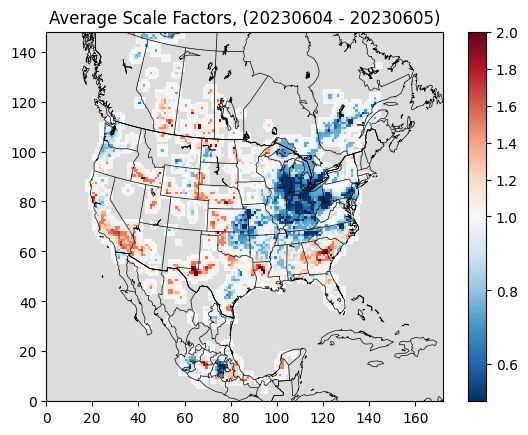

In [80]:

mask = (np.round(scf_avg, 3) != 1)
plt.pcolormesh(np.ma.masked_array(scf_avg, ~mask), cmap='RdBu_r', norm=TwoSlopeNorm(vmin=0.5, vcenter=1.0, vmax=2.0)) #modify
# plt.pcolormesh(scf_avg, cmap=cmap, norm=norm)
cbar = plt.colorbar()
gf = pyrsig.open_ioapi('/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/input/mcip/aqm.t12z.grdcro2d_20230501.ncf')
proj = pyproj.Proj(gf.crs_proj4)
pycno.cno(proj=proj).drawstates()
plt.gca().set(facecolor='gainsboro')
plt.title(f'Average Scale Factors, ({startf} - {endf})')
plt.savefig(f'/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/eval/emissions_scaling_plots/avg_scfs_{run_name}_{startf}-{endf}.png') #modify
plt.show()
plt.close()

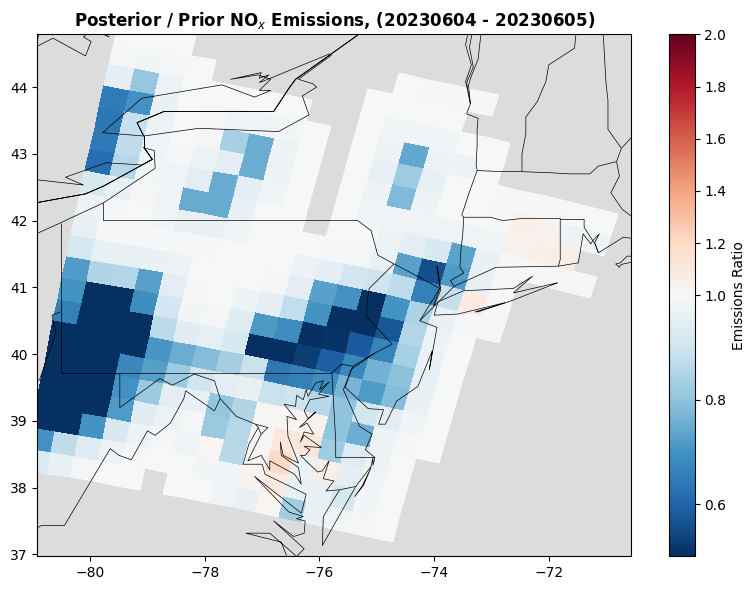

In [81]:
midatlantic_rows = slice(75, 96)
midatlantic_cols = slice(120, 141)

lat = gf['LAT'][0, 0, midatlantic_rows, midatlantic_cols]
lon = gf['LON'][0, 0, midatlantic_rows, midatlantic_cols]

fig, ax = plt.subplots(figsize=(8,6))
pcm = ax.pcolormesh(
    lon, lat,
    np.ma.masked_array(scf_avg[midatlantic_rows, midatlantic_cols], ~mask[midatlantic_rows, midatlantic_cols]),
    cmap='RdBu_r', norm=TwoSlopeNorm(vmin=0.5, vcenter=1.0, vmax=2.0)
)
cbar = plt.colorbar(pcm, ax=ax, label='Emissions Ratio')

# Set limits to subset region
ax.set_xlim(lon.min(), lon.max())
ax.set_ylim(lat.min(), lat.max())

# Draw states clipped to extent
pycno.cno().drawstates(ax=ax)

ax.set(facecolor='gainsboro')
ax.set_title(f"Posterior / Prior NO$_x$ Emissions, ({startf} - {endf})", fontweight='bold')
plt.tight_layout()
plt.savefig(f'/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/manuscript/results/final_plots/case_study_emissions_ratios_midatlantic.png')
plt.savefig(f'/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/manuscript/results/final_plots/case_study_emissions_ratios_midatlantic.pdf')
plt.show()
plt.close()

/tmp/ipykernel_2645046/3700298006.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm = ax.pcolormesh(


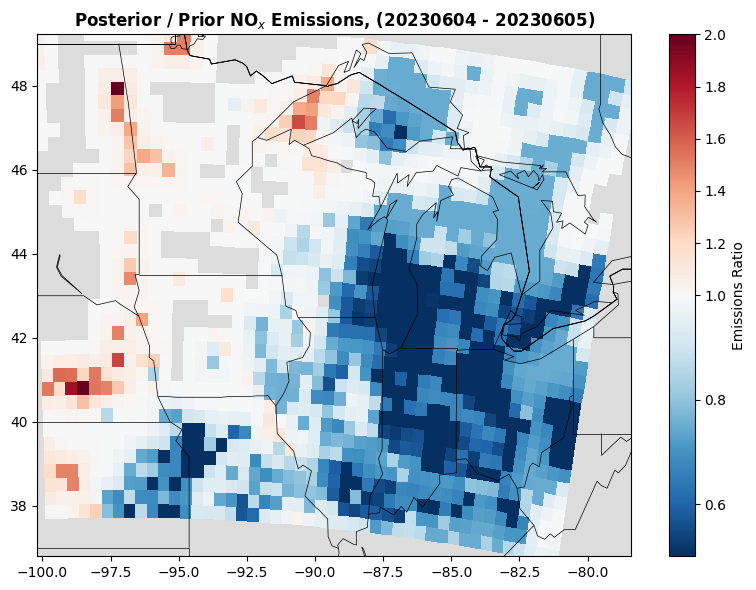

In [82]:
upper_midwest_rows = slice(70, 106)
upper_midwest_cols = slice(75, 121)

lat = gf['LAT'][0, 0, upper_midwest_rows, upper_midwest_cols]
lon = gf['LON'][0, 0, upper_midwest_rows, upper_midwest_cols]

fig, ax = plt.subplots(figsize=(8,6))
pcm = ax.pcolormesh(
    lon, lat,
    np.ma.masked_array(scf_avg[upper_midwest_rows, upper_midwest_cols], ~mask[upper_midwest_rows, upper_midwest_cols]),
    cmap='RdBu_r', norm=TwoSlopeNorm(vmin=0.5, vcenter=1.0, vmax=2.0)
)
cbar = plt.colorbar(pcm, ax=ax, label='Emissions Ratio')

# Set limits to subset region
ax.set_xlim(lon.min(), lon.max())
ax.set_ylim(lat.min(), lat.max())

# Draw states clipped to extent
pycno.cno().drawstates(ax=ax)

ax.set(facecolor='gainsboro')
ax.set_title(f"Posterior / Prior NO$_x$ Emissions, ({startf} - {endf})", fontweight='bold')
plt.tight_layout()
plt.savefig(f'/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/manuscript/results/final_plots/case_study_emissions_ratios_upper_midwest.png')
plt.savefig(f'/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/manuscript/results/final_plots/case_study_emissions_ratios_upper_midwest.pdf')
plt.show()
plt.close()

In [83]:
gf

<xarray.Dataset>
Dimensions:  (TSTEP: 1, VAR: 7, DATE-TIME: 2, LAY: 1, ROW: 148, COL: 172)
Coordinates:
  * TSTEP    (TSTEP) datetime64[ns] 1970-01-01
  * LAY      (LAY) float32 0.9987
  * ROW      (ROW) float64 0.5 1.5 2.5 3.5 4.5 ... 143.5 144.5 145.5 146.5 147.5
  * COL      (COL) float64 0.5 1.5 2.5 3.5 4.5 ... 167.5 168.5 169.5 170.5 171.5
Dimensions without coordinates: VAR, DATE-TIME
Data variables:
    TFLAG    (TSTEP, VAR, DATE-TIME) int32 ...
    LAT      (TSTEP, LAY, ROW, COL) float32 ...
    LON      (TSTEP, LAY, ROW, COL) float32 ...
    MSFX2    (TSTEP, LAY, ROW, COL) float32 ...
    HT       (TSTEP, LAY, ROW, COL) float32 ...
    DLUSE    (TSTEP, LAY, ROW, COL) float32 ...
    LWMASK   (TSTEP, LAY, ROW, COL) float32 ...
    PURB     (TSTEP, LAY, ROW, COL) float32 ...
Attributes: (12/34)
    IOAPI_VERSION:  ioapi-3.2: $Id: init3.F90 200 2021-05-10 14:06:20Z coats ...
    EXEC_ID:                                                                 ...
    FTYPE:          1
    CDATE:          2023305
    CTIME:          11214
    WDATE:          2023305
    ...             ...
    GDNAM:          FV3GFS_NACC-Clou
    UPNAM:          OUTGM3IO        
    VAR-LIST:       LAT             LON             MSFX2           HT       ...
    FILEDESC:       US EPA COMMUNITY MULTISCALE AIR QUALITY MODEL            ...
    HISTORY:        
    crs_proj4:      +proj=lcc +lat_1=33.0 +lat_2=45.0 +lat_0=40.0 +lon_0=-97....

In [84]:
scf_avg

<xarray.DataArray 'SCALE' (ROW: 148, COL: 172)>
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)
Dimensions without coordinates: ROW, COL

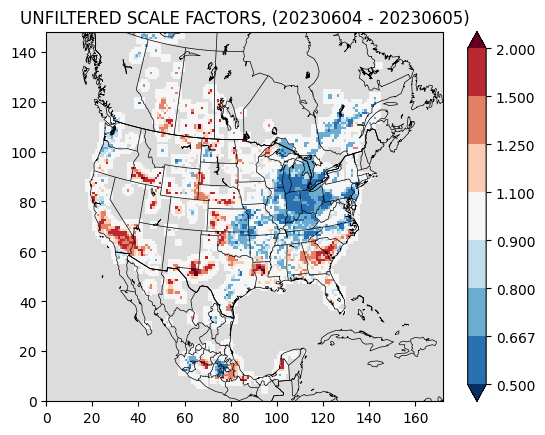

In [85]:
edges = [0.5, 0.667, 0.8, 0.9, 1.1, 1.25, 1.5, 2]
colors = plt.get_cmap('RdBu_r')(np.linspace(0, 1, len(edges) + 1))
cmap, norm = plt.matplotlib.colors.from_levels_and_colors(
    edges, colors, extend='both'
)
mask = (np.round(scf_avg, 3) != 1)
plt.pcolormesh(np.ma.masked_array(scf_avg, ~mask), cmap=cmap, norm=norm)
# plt.pcolormesh(scf_avg, cmap=cmap, norm=norm)
cbar = plt.colorbar()
gf = pyrsig.open_ioapi('/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/input/mcip/aqm.t12z.grdcro2d_20230501.ncf')
proj = pyproj.Proj(gf.crs_proj4)
pycno.cno(proj=proj).drawstates()
plt.gca().set(facecolor='gainsboro')
plt.title(f'UNFILTERED SCALE FACTORS, ({startf} - {endf})')
plt.savefig(f'/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/eval/emissions_scaling_plots/avg_scfs_{run_name}_{startf}-{endf}.png') #modify
plt.show()
plt.close()

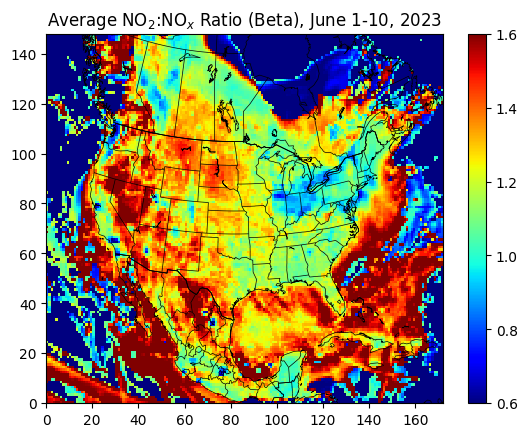

In [86]:
# # edges = [0.5, 0.75, 0.9, 1.1, 1.25, 1.5, 2]
# colors = plt.get_cmap('RdBu_r')(np.linspace(0, 1, len(edges) + 1))
# cmap, norm = plt.matplotlib.colors.from_levels_and_colors(
#     edges, colors, extend='both'
# )
# mask = (np.round(beta, 3) != 1)
# plt.pcolormesh(np.ma.masked_array(beta, ~mask), cmap=cmap, norm=norm)
plt.pcolormesh(beta, cmap='jet', vmin=0.6, vmax=1.6)
cbar = plt.colorbar()
gf = pyrsig.open_ioapi('/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/input/mcip/aqm.t12z.grdcro2d_20230501.ncf')
proj = pyproj.Proj(gf.crs_proj4)
pycno.cno(proj=proj).drawstates()
plt.gca().set(facecolor='gainsboro')
plt.title(f'Average NO$_2$:NO$_x$ Ratio (Beta), June 1-10, 2023')
plt.savefig(f'/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/eval/emissions_scaling_plots/avg_beta_{run_name}_{startf}-{endf}.png') #modify
plt.show()
plt.close()